# Correlation analysis for IFN-B response

Demonstrating differential expression between cell types and the effect of interferon stimulation within a cell type (CD4 T cells).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import collections
import gseapy
from matplotlib.colors import ListedColormap

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [ ]:
import warnings
# warnings.filterwarnings('ignore')

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/schypo')
import estimator, simulate, schypo, bootstrap, util, hypothesis_test

In [ ]:
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig5/'
data_path = '/data/parameter_estimation/'

### Load the data

In [ ]:
cts = ['CD4 T cells',  'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'NK cells','CD8 T cells', 'B cells']
label_converter = dict(zip(cts, ['Th', 'cM', 'ncM', 'NK', 'Tc', 'B']))

In [ ]:
def simplify_name(name):
    return name.split('.')[0]

In [ ]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')


In [ ]:
sc.pl.tsne(adata, color='cell_type')

In [ ]:
# plt.figure(figsize=(5, 3))
# sns.boxplot(x='n_counts', y='cell_type', data=adata.obs)
# plt.title('Total UMI counts by cell type')
# plt.savefig('celltype_numi.pdf')
# plt.savefig('celltype_numi.png')

In [ ]:
print('Number of genes kept:', adata.shape[1])

In [ ]:
with open(data_path + 'all_highcount_tfs.pkl', 'rb') as f:
	tfs = pkl.load(f)

In [ ]:
tf_df = pd.read_csv('attribute_list_entries.txt', sep='\t')
tfs = tf_df['GeneSym'].tolist()

In [ ]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

### Read the transcriptome wide IFN result

In [ ]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()

schypo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.00, 
    min_perc_group=0.99)

target_genes = adata_ct.var.index.tolist()

schypo.compute_2d_moments(
    adata_ct, 
    target_genes, 
    target_genes)

In [ ]:
adata_ct.uns['schypo']['2d_ht'] = {
    'corr_asl':np.zeros((len(target_genes), len(target_genes))),
    'corr_coef':np.zeros((len(target_genes), len(target_genes))),
}

In [ ]:
genes_per_batch = 20
for batch in range(int(len(target_genes)/genes_per_batch)+1):
    
    adata_chunk = sc.read(data_path + 'result_2d/mono_ifn/{}.h5ad'.format(batch))
    adata_ct.uns['schypo']['2d_ht']['corr_asl'][(genes_per_batch*batch):(genes_per_batch*(batch+1)), :] = adata_chunk.uns['schypo']['2d_ht']['corr_asl']
    adata_ct.uns['schypo']['2d_ht']['corr_coef'][(genes_per_batch*batch):(genes_per_batch*(batch+1)), :] = adata_chunk.uns['schypo']['2d_ht']['corr_coef']

In [ ]:
adata_ct.write(data_path + 'result_2d/mono_ifn/combined.h5ad')

In [ ]:
imp.reload(schypo)

In [ ]:
adata_ct = sc.read(data_path + 'result_2d/mono_ifn/combined.h5ad')

### Get the results

In [ ]:
js_genes = pd.read_csv('jakstat_genes.txt', sep='\t', header=None)[1].apply(lambda x: x.split(';')[0]).tolist()

In [ ]:
imp.reload(schypo)

In [ ]:
mono_result_df = schypo.get_2d_ht_result(adata_ct)

In [ ]:
mono_result_df.head(5)

In [ ]:
ctrl_mean_corr = 0
stim_mean_corr = 0

ctrl_count = 0
stim_count = 0

for group in adata_ct.uns['schypo']['groups']:
    
    temp = adata_ct.uns['schypo']['2d_moments'][group]['corr'].copy()
    temp[(temp > 1) | (temp < -1)] = 0
    
    if 'ctrl' in group:
        ctrl_mean_corr += temp
        ctrl_count += ~np.isnan(temp)
        
    if 'stim' in group:
        stim_mean_corr += temp
        stim_count += ~np.isnan(temp)

ctrl_mean_corr /= ctrl_count
stim_mean_corr /= stim_count

del ctrl_count, stim_count

In [ ]:
mono_result_df['ctrl_corr'] = ctrl_mean_corr.ravel()
mono_result_df['stim_corr'] = stim_mean_corr.ravel()

In [ ]:
mono_result_df['tf'] = mono_result_df['gene_1'].isin(tfs) | mono_result_df['gene_2'].isin(tfs)


In [ ]:
mono_result_df.shape

In [ ]:
sns.distplot(mono_result_df['ctrl_corr'])
sns.distplot(mono_result_df['stim_corr'])

In [ ]:
sig_df = mono_result_df.query('corr_fdr < 0.1').copy()
sig_df['mag'] = sig_df['corr_coef'].abs()
del mono_result_df

In [ ]:
sig_df['js'] = sig_df['gene_1'].isin(js_genes) | sig_df['gene_2'].isin(js_genes)
sig_df['tf'] = sig_df['gene_1'].isin(tfs) | sig_df['gene_2'].isin(tfs)


In [ ]:
sig_df.query('stim_corr < -0.3 & (js & tf)')

In [ ]:
sig_df.query('gene_1 == "JAK2" & gene_2 == "STAT5B"')

In [ ]:
sig_df.query('tf & stim_corr > -.1 & stim_corr < 0.1').sort_values('ctrl_corr', ascending=False).head(10)

In [ ]:
sig_df.query('tf & ctrl_corr > -.1 & ctrl_corr < 0.1 & corr_coef > 0 & stim_corr > 0').sort_values('stim_corr', ascending=False).head(100)

### Plot some examples

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6083555/

https://pubmed.ncbi.nlm.nih.gov/12901872/

https://pubmed.ncbi.nlm.nih.gov/23399697/

https://www.nature.com/articles/ni.1897

In [ ]:
def get_ind_corr(adata, gene_1, gene_2):
    
    idx_1 = np.where(adata_ct.uns['schypo']['2d_moments']['gene_1'] == gene_1)[0][0]
    idx_2 = np.where(adata_ct.uns['schypo']['2d_moments']['gene_2'] == gene_2)[0][0]
    
    df_list = []
    for group in adata.uns['schypo']['groups']:
        _, stim, ind = group.split('^')
        df_list.append((stim,ind,adata.uns['schypo']['2d_moments'][group]['corr'][idx_1][idx_2]))
    return pd.DataFrame(df_list, columns=[ 'stim','ind', 'corr']).query('corr < 1 & corr > -1')


def variability_scatter(X, c, vmin=None, vmax=None, xlim=None, ylim=None, s=5):
    
    order = np.argsort(c)
    c = np.clip(c, a_min=0, a_max=np.quantile(c, 0.995))
    plt.scatter(X[order, 0], X[order, 1], c=c[order], cmap='viridis', s=s, vmin=vmin, vmax=vmax)

    plt.colorbar(orientation='horizontal');
    if xlim is not None and ylim is not None:
        plt.xlim(xlim);
        plt.ylim(ylim);
    plt.xticks([]); plt.yticks([]);
    
    
def plot_microscopy(X, c1, c2, s=5, end_num=-5, alpha=0.1, xlim=None, ylim=None, remove_axis=True):
    
    N = X.shape[0]
    
    prod = c1*c2
    
    c1 = np.clip(c1, a_min=0, a_max=np.sort(c1)[end_num])
    c2 = np.clip(c2, a_min=0, a_max=np.sort(c2)[end_num])
    prod = np.clip(prod, a_min=0, a_max=np.sort(prod)[end_num])
    
    print(prod.min(), prod.max())

    c1 = (c1 - c1.min())/(c1.max()-c1.min())
    c2 = (c2 - c2.min())/(c2.max()-c2.min())
    prod = (prod - prod.min())/(prod.max()-prod.min())
    order_1 = np.argsort(c1)
    order_2 = np.argsort(c2)
    order_prod = np.argsort(prod)
    
    print(prod)
    ListedColormap(sns.dark_palette("red", 100).as_hex())
        
    plt.subplot(1, 3, 1); 
        
    plt.scatter(X[order_1, 0], X[order_1, 1], c=c1[order_1], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("red", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    plt.title(gene_1)
        
    plt.subplot(1, 3, 2); 
    plt.scatter(X[order_2, 0], X[order_2, 1], c=c2[order_2], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("green", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    plt.title(gene_2)

        
    plt.subplot(1, 3, 3); 
    plt.scatter(X[order_prod, 0], X[order_prod, 1], c=prod[order_prod], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("orange", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    plt.title(gene_1 + ' * ' + gene_2)
        

norm_adata = adata.copy()
norm_adata = norm_adata[norm_adata.obs.cell == 'CD14+ Monocytes'].copy()
norm_adata = norm_adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
dat = norm_adata

0.0 466.48538
[0.         0.         0.         ... 0.         0.         0.11938571]


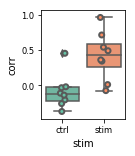

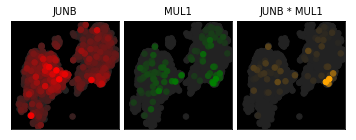

In [328]:
gene_1, gene_2 = 'JUNB', 'MUL1'

plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    end_num=-2,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')

0.0 3918.0447
[0.         0.00829291 0.00654636 ... 0.         0.09384734 0.        ]


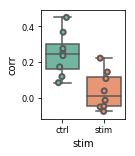

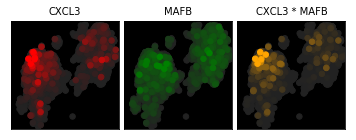

In [329]:
gene_1, gene_2 = 'CXCL3', 'MAFB'


plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    end_num=-5,
    s=30,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')

0.0 15.759546
[0. 0. 0. ... 0. 0. 0.]


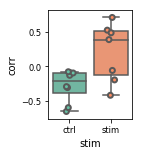

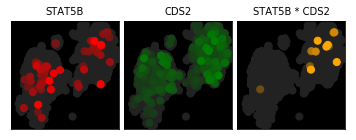

In [330]:
gene_1, gene_2 = 'STAT5B', 'CDS2'

plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    end_num=-5,
    s=50,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')

0.0 143.48026
[0. 0. 0. ... 0. 0. 0.]


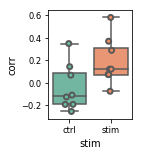

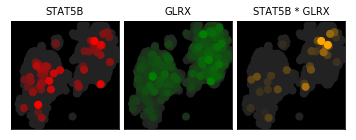

In [331]:
gene_1, gene_2 = 'STAT5B', 'GLRX'

plt.figure(figsize=(1.5, 2))

sns.boxplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2')
sns.stripplot(x='stim', y='corr',
    data=get_ind_corr(adata_ct, gene_1, gene_2), 
    palette='Set2', dodge=True, linewidth=2)

plt.savefig(fig_path + '{}_{}_box.pdf'.format(gene_1, gene_2), bbox_inches='tight')

plt.figure(figsize=(6, 2))
plt.subplots_adjust(wspace=0.05)

plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    end_num=-2,
    s=50,
    alpha=1,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

plt.savefig(fig_path + '{}_{}_scatter.pdf'.format(gene_1, gene_2), bbox_inches='tight')

### P-value histogram

In [ ]:
mono_result_df.query('tf').corr_pval.hist(bins=80)
plt.xlabel('p-value');
plt.savefig(fig_path + 'dc_pval_hist.pdf', bbox_inches='tight')

### Network figure

In [ ]:
import networkx as nx

In [ ]:
max_corr = 0.1

In [ ]:
stim_corr_df = sig_df.query('tf & ctrl_corr > {} & ctrl_corr < {} & corr_coef > 0 & stim_corr > {}'.format(-max_corr, max_corr, max_corr)).sort_values('stim_corr', ascending=False)
ctrl_corr_df = sig_df.query('tf & stim_corr > {} & stim_corr < {} & corr_coef < 0 & ctrl_corr > {}'.format(-max_corr, max_corr, max_corr)).sort_values('ctrl_corr', ascending=False)
network_tfs = list(set(stim_corr_df.gene_1.tolist() + stim_corr_df.gene_2.tolist() + ctrl_corr_df.gene_1.tolist() + ctrl_corr_df.gene_2.tolist()) & set(tfs))

In [ ]:
print(stim_corr_df.shape[0], ctrl_corr_df.shape[0])

In [ ]:
all_stim_corr_df = mono_result_df.query('tf & ctrl_corr > {} & ctrl_corr < {} & corr_coef > 0 & stim_corr > 0.15 & (gene_1 in @network_tfs) & corr_fdr > 0.1'.format(-max_corr, max_corr))
all_ctrl_corr_df = mono_result_df.query('tf & stim_corr > {} & stim_corr < {} & corr_coef < 0 & ctrl_corr > 0.15 & (gene_1 in @network_tfs) & corr_fdr > 0.1'.format(-max_corr, max_corr))

In [ ]:
def get_graph(key):
    G = nx.Graph()
    
    corr_col = key + '_corr'
    
    print(corr_col)

    for idx, row in all_stim_corr_df.iterrows():
        G.add_edge(row['gene_1'], row['gene_2'], weight=row[corr_col], significant=False)
    for idx, row in all_ctrl_corr_df.iterrows():
        G.add_edge(row['gene_1'], row['gene_2'], weight=row[corr_col], significant=False)
    for idx, row in stim_corr_df.iterrows():
        G.add_edge(row['gene_1'], row['gene_2'], weight=row[corr_col], significant=True)
    for idx, row in ctrl_corr_df.iterrows():
        G.add_edge(row['gene_1'], row['gene_2'], weight=row[corr_col], significant=True)
        
    return G

In [ ]:
stim_G = get_graph('stim')
ctrl_G = get_graph('ctrl')

In [ ]:
left_genes = set(all_ctrl_corr_df.gene_1.tolist() + all_ctrl_corr_df.gene_2.tolist() + ctrl_corr_df.gene_1.tolist() + ctrl_corr_df.gene_2.tolist()) - set(network_tfs)
right_genes = set(all_stim_corr_df.gene_1.tolist() + stim_corr_df.gene_1.tolist() + all_stim_corr_df.gene_2.tolist() + stim_corr_df.gene_2.tolist())- set(network_tfs)
overlap = left_genes & right_genes
left_genes -= overlap
right_genes -= overlap

stim_G.remove_nodes_from(overlap)
ctrl_G.remove_nodes_from(overlap)

left_pos_y = np.linspace(-5, 5, len(left_genes))
right_pos_y = np.linspace(-5, 5, len(right_genes))
middle_pos_y = np.linspace(-5, 5, len(network_tfs))

pos = dict(zip(list(left_genes), np.vstack([np.ones(len(left_pos_y))*-5, left_pos_y,]).T))
pos.update(dict(zip(list(network_tfs), np.vstack([np.ones(len(middle_pos_y))*0, middle_pos_y, ]).T)))
pos.update(dict(zip(list(right_genes), np.vstack([np.ones(len(right_pos_y))*5, right_pos_y, ]).T)))


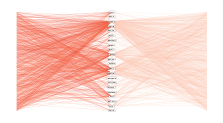

In [321]:
plt.figure(figsize=(3.75, 2))
nx.draw_networkx(
    ctrl_G, 
    pos=pos, 
    labels={node:(node if node in network_tfs else '') for node in ctrl_G.nodes()},
    font_size=2.2,
    node_size=0,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', linewidth=0.1),
    edge_color=[ctrl_G[u][v]['weight'] for u,v in ctrl_G.edges()],
    edge_cmap=plt.get_cmap('Reds'),
    width=0.1,
    edge_vmin=-0.1,
    edge_vmax=0.5)
plt.axis('off')

# sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Reds'), norm=plt.Normalize(vmin = -0.1, vmax=0.5))
# sm._A = []
# plt.colorbar(sm)
# plt.show()

plt.savefig(fig_path + 'ctrl_network.png', bbox_inches='tight')

In [324]:
for u, v in stim_G.edges():
    print(u, v, stim_G[u][v])
    break

YBX1 ID3 {'weight': 0.2646107647451572, 'significant': False}


In [325]:
for u, v in stim_G.edges():
    print(u, v, ctrl_G[u][v])
    break

YBX1 ID3 {'weight': -0.062226095236837864, 'significant': False}


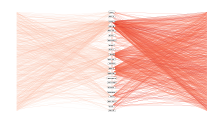

In [326]:
plt.figure(figsize=(3.75, 2))
nx.draw_networkx(
    ctrl_G, 
    pos=pos, 
    labels={node:(node if node in network_tfs else '') for node in ctrl_G.nodes()},
    font_size=2.2,
    node_size=0,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', linewidth=0.1),
    edge_color=[stim_G[u][v]['weight'] for u,v in stim_G.edges()],
    edge_cmap=plt.get_cmap('Reds'),
    width=0.1,
    edge_vmin=-0.1,
    edge_vmax=0.5)
plt.axis('off')

plt.savefig(fig_path + 'stim_network.png', bbox_inches='tight')

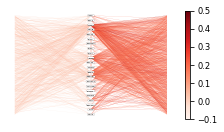

<Figure size 432x288 with 0 Axes>

In [327]:
plt.figure(figsize=(3.75, 2))
nx.draw_networkx(
    ctrl_G, 
    pos=pos, 
    labels={node:(node if node in network_tfs else '') for node in ctrl_G.nodes()},
    font_size=2.2,
    node_size=0,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', linewidth=0.1),
    edge_color=[stim_G[u][v]['weight'] for u,v in stim_G.edges()],
    edge_cmap=plt.get_cmap('Reds'),
    width=0.1,
    edge_vmin=-0.1,
    edge_vmax=0.5)
plt.axis('off')
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('Reds'), norm=plt.Normalize(vmin = -0.1, vmax=0.5))
sm._A = []
plt.colorbar(sm)
plt.show()

plt.savefig(fig_path + 'network_colorbar.pdf', bbox_inches='tight')

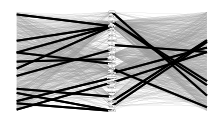

In [332]:
plt.figure(figsize=(3.75, 2))

nx.draw_networkx(
    ctrl_G, 
    pos=pos, 
    labels={node:(node if node in network_tfs else '') for node in ctrl_G.nodes()},
    font_size=2.2,
    node_size=0,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', linewidth=0.1),
    edge_color=[6 if stim_G[u][v]['significant'] else 0.5 for u,v in G.edges()],
    edge_cmap=plt.get_cmap('Greys'),
    width=[2 if stim_G[u][v]['significant'] else 0.1 for u,v in G.edges()],
    edge_vmin=0,
    edge_vmax=1)

nx.draw_networkx(
    ctrl_G, 
    pos=pos, 
    labels={node:(node if node in network_tfs else '') for node in ctrl_G.nodes()},
    font_size=2.2,
    node_size=0,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', linewidth=0.1),
    edge_color=[6 if stim_G[u][v]['significant'] else 0.5 for u,v in G.edges()],
    edge_cmap=plt.get_cmap('Greys'),
    width=[2 if stim_G[u][v]['significant'] else 0 for u,v in G.edges()],
    edge_vmin=0,
    edge_vmax=1)
plt.axis('off')

plt.savefig(fig_path + 'network_significant.png', bbox_inches='tight')

In [ ]:
a = nx.circular_layout(G)

In [ ]:
G

In [ ]:
all_stim_corr_df.shape

In [ ]:
all_ctrl_corr_df.shape

In [ ]:
stim_corr_df.shape

In [ ]:
ctrl_corr_df.shape

In [ ]:
network_tfs = list(set(stim_corr_df.gene_1.tolist() + stim_corr_df.gene_2.tolist() + ctrl_corr_df.gene_1.tolist() + ctrl_corr_df.gene_2.tolist()) & set(tfs))

In [ ]:
network_tfs

### Plotting

In [ ]:
from matplotlib.colors import ListedColormap


In [ ]:
sns.palplot(sns.dark_palette("purple", 100))


In [ ]:
def get_ind_corr(adata, gene_1, gene_2):
    
    idx_1 = np.where(adata_ct.uns['schypo']['2d_moments']['gene_1'] == gene_1)[0][0]
    idx_2 = np.where(adata_ct.uns['schypo']['2d_moments']['gene_2'] == gene_2)[0][0]
    
    df_list = []
    for group in adata.uns['schypo']['groups']:
        _, stim, ind = group.split('^')
        df_list.append((stim,ind,adata.uns['schypo']['2d_moments'][group]['corr'][idx_1][idx_2]))
    return pd.DataFrame(df_list, columns=[ 'stim','ind', 'corr']).query('corr < 1 & corr > -1')


def variability_scatter(X, c, vmin=None, vmax=None, xlim=None, ylim=None, s=5):
    
    order = np.argsort(c)
    c = np.clip(c, a_min=0, a_max=np.quantile(c, 0.995))
    plt.scatter(X[order, 0], X[order, 1], c=c[order], cmap='viridis', s=s, vmin=vmin, vmax=vmax)

    plt.colorbar(orientation='horizontal');
    if xlim is not None and ylim is not None:
        plt.xlim(xlim);
        plt.ylim(ylim);
    plt.xticks([]); plt.yticks([]);
    
    
def plot_microscopy(X, c1, c2, s=5, end_num=-5, alpha=0.1, xlim=None, ylim=None, remove_axis=True):
    
    N = X.shape[0]
    
    prod = c1*c2
    
    c1 = np.clip(c1, a_min=0, a_max=np.sort(c1)[end_num])
    c2 = np.clip(c2, a_min=0, a_max=np.sort(c2)[end_num])
    prod = np.clip(prod, a_min=0, a_max=np.sort(prod)[end_num])
    
    print(prod.min(), prod.max())

    c1 = (c1 - c1.min())/(c1.max()-c1.min())
    c2 = (c2 - c2.min())/(c2.max()-c2.min())
    prod = (prod - prod.min())/(prod.max()-prod.min())
    order_1 = np.argsort(c1)
    order_2 = np.argsort(c2)
    order_prod = np.argsort(prod)
    
    print(prod)
    ListedColormap(sns.dark_palette("red", 100).as_hex())
        
    plt.subplot(2, 3, 4); 
        
    plt.scatter(X[order_1, 0], X[order_1, 1], c=c1[order_1], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("red", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
        
    plt.subplot(2, 3, 5); 
    plt.scatter(X[order_2, 0], X[order_2, 1], c=c2[order_2], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("green", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if remove_axis:
        plt.xticks([]); plt.yticks([])
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
        
    plt.subplot(2, 3, 6); 
    plt.scatter(X[order_prod, 0], X[order_prod, 1], c=prod[order_prod], s=s, alpha=alpha, cmap=ListedColormap(sns.dark_palette("orange", 100).as_hex()))
    plt.gca().set_facecolor((0, 0, 0))
    if xlim is not None and ylim is not None:
        plt.xlim(xlim); plt.ylim(ylim);
    if remove_axis:
        plt.xticks([]); plt.yticks([])
        

norm_adata = adata.copy()
norm_adata = norm_adata[norm_adata.obs.cell == 'CD14+ Monocytes'].copy()
norm_adata = norm_adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
dat = norm_adata

In [ ]:
for idx, row in js_sig_df.iterrows():

    gene_1, gene_2 = row['gene_1'], row['gene_2']

    plt.figure(figsize=(6, 6))

    plt.subplots_adjust(wspace=0.1)

    plt.subplot(2, 3, 1)
    sns.boxplot(x='stim', y='corr',
        data=get_ind_corr(adata_ct, gene_1, gene_2), 
        palette='Set2')
    sns.stripplot(x='stim', y='corr',
        data=get_ind_corr(adata_ct, gene_1, gene_2), 
        palette='Set2', dodge=True, linewidth=2)

    plt.subplot(2, 3, 2)
    variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_1].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
    plt.title(gene_1)

    plt.subplot(2, 3, 3)
    variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_2].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
    plt.title(gene_2)

    plot_microscopy(
        X=dat.obsm['X_tsne'],
        c1=dat[:,gene_1].X.todense().A1,
        c2=dat[:,gene_2].X.todense().A1,
        end_num=-5,
        alpha=1,
        remove_axis=True,
        xlim=(-40, 20), 
        ylim=(3, 40))

    plt.savefig('/data/parameter_estimation/fig5_candidates/{}_{}.png'.format(gene_1, gene_2), bbox_inches='tight')

    plt.close()

In [ ]:
plot_microscopy(
    X=dat.obsm['X_tsne'],
    c1=dat[:,gene_1].X.todense().A1,
    c2=dat[:,gene_2].X.todense().A1,
    s=1,
    q_down=0.5,
    q_up=0.9, 
    alpha=0.5,
    remove_axis=True,
    xlim=(-40, 20), 
    ylim=(3, 40))

*****

### Get the correlation matrix for control cells, construct the neareast neighbor graph, and get gene clusters

In [ ]:
# mat = adata_ct.uns['schypo']['2d_ht']['corr_coef']#[:, isg_indices][isg_indices, :]
# mat[np.absolute(mat) > 2] = np.nan
# mat[np.isnan(mat)] = 0

heatmap_df = pd.DataFrame(
    adata_ct.uns['schypo']['2d_ht']['corr_asl'],
    index=target_genes,
    columns=target_genes).fillna(0.0)
heatmap_df[heatmap_df.abs() > 2] = 0

heatmap_df[:] = -np.log10(heatmap_df.values)

In [ ]:
adata_ct = adata[adata.obs.cell == 'CD14+ Monocytes']
schypo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.00, 
    min_perc_group=0.99)

target_genes = adata_ct.var.index.tolist()

schypo.create_groups(adata_ct, label_columns=['stim'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.00, 
    min_perc_group=0.99)


schypo.compute_2d_moments(
    adata_ct, 
    target_genes, 
    target_genes)

corr_mat = adata_ct.uns['schypo']['2d_moments']['sg^ctrl']['corr'].copy()
del adata_ct

In [ ]:
corr_mat[np.isnan(corr_mat) | (corr_mat < -2) | (corr_mat > 2) | (corr_mat == 0)] = 1e-10
corr_mat = np.absolute(corr_mat)

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
neigh = NearestNeighbors(n_neighbors=10, metric='precomputed').fit(1/corr_mat)
neighbor_graph = neigh.kneighbors_graph()

In [ ]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
test_adata = sc.AnnData(adata_ct[:, target_genes].X.T)
test_adata.obs.index = target_genes
sc.pp.pca(test_adata)
sc.pp.neighbors(test_adata, n_neighbors=10, metric='correlation')
test_adata.uns['neighbors']['connectivities'] = neighbor_graph
test_adata.uns['neighbors']['distances'] = neighbor_graph.multiply(1/corr_mat)

In [ ]:
sc.tl.umap(test_adata)

In [ ]:
sc.tl.leiden(test_adata, resolution=0.9)


In [ ]:
print(test_adata.obs.loc['STAT5B'], test_adata.obs.loc['TYK2'], test_adata.obs.loc['JAK2'])

In [ ]:
# sc.pl.umap(test_adata[test_adata.obs.leiden == '9'], color='leiden')
sc.pl.umap(test_adata, color='leiden')

In [ ]:
import gseapy

In [ ]:
test_adata.shape

In [ ]:
test_adata.obs.loc['ISG15']

In [ ]:
test_adata.obs.query('leiden == "2"').shape

In [ ]:
for cluster in test_adata.obs.leiden.drop_duplicates().astype(str).sort_values():
    
    print('cluster', cluster, '---------')
    
    kegg_df = gseapy.enrichr(
        gene_list=test_adata.obs.query('leiden == "{}"'.format(cluster)).index.tolist(), 
        description='pathway', gene_sets='KEGG_2019_Human', outdir='gsea').res2d
    if kegg_df[kegg_df['Adjusted P-value'] < 0.1].shape[0] > 0:
        print(kegg_df.head(5).to_string())

### Compute DC for STAT genes

In [ ]:
len(target_genes)

In [ ]:
adata_ct = adata[adata.obs.cell == 'CD14+ Monocytes']
schypo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.00, 
    min_perc_group=0.87)


# target_genes = adata_ct.var.index.tolist()

# print('STAT1' in target_genes, 'STAT2' in target_genes)

schypo.compute_2d_moments(
    adata_ct, 
    ['STAT1', 'STAT2'], 
    target_genes)

schypo.ht_2d_moments(
    adata_ct, 
    formula_like='1 + stim', 
    cov_column='stim', 
    num_cpus=6, 
    num_boot=2500)

# corr_mat = adata_ct.uns['schypo']['2d_moments']['sg^ctrl']['corr'].copy()

### Read DC result and combine with STAT1 and STAT2

In [ ]:
ct = 'CD14+ Monocytes'


norm_adata = adata.copy()
norm_adata = norm_adata[norm_adata.obs.cell == ct].copy()
norm_adata = norm_adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
dat = norm_adata[(norm_adata.obs.cell == ct)]


def variability_scatter(X, c, vmin, vmax, xlim=None, ylim=None, s=5):
    
    order = np.argsort(c)
    print(c[order][-1])
    c = np.clip(c, a_min=0, a_max=np.quantile(c, 0.995))
    plt.scatter(X[order, 0], X[order, 1], c=c[order], cmap='viridis', s=s, vmin=vmin, vmax=vmax)

    plt.colorbar(orientation='horizontal');
    if xlim is not None and ylim is not None:
        plt.xlim(xlim);
        plt.ylim(ylim);
    plt.xticks([]); plt.yticks([]);

In [ ]:
dc_result = sc.read(data_path + 'result_2d/mono_ifn/combined.h5ad')

In [ ]:
dc_result.uns['schypo']['2d_ht']['corr_asl'] = np.vstack([
    dc_result.uns['schypo']['2d_ht']['corr_asl'],
    adata_ct.uns['schypo']['2d_ht']['corr_asl']
])

In [ ]:
dc_result.uns['schypo']['2d_ht']['corr_coef'] = np.vstack([
    dc_result.uns['schypo']['2d_ht']['corr_coef'],
    adata_ct.uns['schypo']['2d_ht']['corr_coef']
])

In [ ]:
dc_result.uns['schypo']['2d_moments']['gene_1'] = np.concatenate([
    dc_result.uns['schypo']['2d_moments']['gene_1'],
    np.array(['STAT1', 'STAT2'])
])

In [ ]:
mono_result_df = schypo.get_2d_ht_result(dc_result).query('corr_coef > -2 & corr_coef < 2')

In [ ]:
sig_df = mono_result_df.query('corr_fdr < 0.1').copy()
sig_df['mag'] = sig_df['corr_coef'].abs()
sig_df['tf_corr'] = sig_df['gene_1'].isin(tfs) | sig_df['gene_2'].isin(tfs)

In [ ]:
sig_df

In [ ]:
js_genes = pd.read_csv('jakstat_genes.txt', sep='\t', header=None)[1].apply(lambda x: x.split(';')[0]).tolist()

In [ ]:
adata_temp = adata[adata.obs.cell == 'CD14+ Monocytes']
schypo.create_groups(adata_temp, label_columns=['stim'], inplace=True, q=0.07)

schypo.compute_1d_moments(
    adata_temp, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.00, 
    min_perc_group=0.87)

mean_df = pd.DataFrame()
mean_df['gene'] = adata_temp.var.index.tolist()
mean_df['stim_mean'] = np.log(adata_temp.uns['schypo']['1d_moments']['sg^stim'][0])
# mean_df['ctrl_mean'] = np.log(adata_temp.uns['schypo']['1d_moments']['sg^ctrl'][0])

sig_df = sig_df.merge(mean_df.rename(columns={'gene':'gene_1'}), on='gene_1', how='left')
sig_df = sig_df.merge(mean_df.rename(columns={'gene':'gene_2'}), on='gene_2', how='left')

In [ ]:
min_mean=-11.6
sig_df.query('(gene_1 in @js_genes | gene_2 in @js_genes) & stim_mean_x > {} & stim_mean_y > {}'.format(min_mean, min_mean)).head(10)

In [ ]:
sig_df[sig_df.gene_1.str.contains("IRF") | sig_df.gene_2.str.contains("IRF")]

In [ ]:
'IRF9' in js_genes

In [ ]:
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'IRF8'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=30, vmin=0, vmax=10)
plt.figure()
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'DDIT4'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=30, vmin=0, vmax=10)


In [ ]:
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'ZCRB1'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=30, vmin=0, vmax=5)
plt.figure()
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'PIM1'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=30, vmin=0, vmax=5)


In [ ]:
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'SOCS3'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=10, vmin=0, vmax=10)


In [ ]:
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'STAT2'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=10, vmin=0, vmax=12)


In [ ]:
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'STAT2'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=20, vmin=0, vmax=12)


In [ ]:
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'JAK2'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=15, vmin=0, vmax=8)


In [ ]:
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'PIM1'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=12, vmin=0, vmax=4)


In [ ]:
ct = 'CD14+ Monocytes'


norm_adata = adata.copy()
norm_adata = norm_adata[norm_adata.obs.cell == ct].copy()
norm_adata = norm_adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
dat = norm_adata[(norm_adata.obs.cell == ct)]


def variability_scatter(X, c, vmin, vmax, xlim=None, ylim=None, s=5):
    
    order = np.argsort(c)
    print(c[order][-1])
    c = np.clip(c, a_min=0, a_max=np.quantile(c, 0.995))
    plt.scatter(X[order, 0], X[order, 1], c=c[order], cmap='viridis', s=s, vmin=vmin, vmax=vmax)

    plt.colorbar(orientation='horizontal');
    if xlim is not None and ylim is not None:
        plt.xlim(xlim);
        plt.ylim(ylim);
    plt.xticks([]); plt.yticks([]);

In [ ]:
dat[:, 'STAT5B'].X.max()

In [ ]:
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'STAT2'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=50, vmin=0, vmax=12)


In [ ]:
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'TYK2'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=20, vmin=0, vmax=6)


In [ ]:
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'JAK2'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=12, vmin=0, vmax=8)


In [ ]:
sc.pl.umap(dc_result)

In [ ]:
sig_df.query('gene_1 == "TYK2" | gene_2 == "TYK2"')

In [ ]:
sig_df.query('gene_1 == "JAK2" | gene_2 == "JAK2"')

In [ ]:
print(test_adata.obs.loc['STAT5B'], test_adata.obs.loc['TYK2'], test_adata.obs.loc['JAK2'])

In [ ]:
cluster_sig_dict = {}
for cluster in test_adata.obs.leiden.drop_duplicates().astype(str).sort_values():
    print('cluster', cluster, '---------')
    gene_list=test_adata.obs.query('leiden == "{}"'.format(cluster)).index.tolist()
    
    s = sig_df.query('gene_1 in @gene_list & gene_2 in @gene_list')
    
    cluster_sig_dict[cluster] = s
    
    print(len(s)/(len(gene_list)*(len(gene_list)-1)/2), len(s), len(gene_list))

In [ ]:
cluster_sig_dict['4']

In [ ]:
gene_list

### Plotting functions

In [ ]:
def get_ind_corr(adata, gene_1, gene_2):
    
    adata_temp = adata.copy()
    scmemo.create_groups(adata_temp, label_columns=['stim','ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_temp, inplace=True, filter_genes=False, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.0, 
        min_perc_group=0.0)
    scmemo.compute_2d_moments(adata_temp, [gene_1], [gene_2])
    df_list = []
    for group in adata_temp.uns['scmemo']['groups']:
        _, stim, ind = group.split('^')
        df_list.append((stim,ind,adata_temp.uns['scmemo']['2d_moments'][group]['corr'][0][0]))
    return pd.DataFrame(df_list, columns=[ 'stim','ind', 'corr'])

def get_ct_ind_corr(adata, gene_1, gene_2):
    
    adata_temp = adata.copy()
    scmemo.create_groups(adata_temp, label_columns=['cell','stim','ind'], inplace=True)
    scmemo.compute_1d_moments(
        adata_temp, inplace=True, filter_genes=False, 
        residual_var=True, use_n_umi=False, filter_mean_thresh=0.0, 
        min_perc_group=0.0)
    scmemo.compute_2d_moments(adata_temp, [gene_1], [gene_2])
    df_list = []
    for group in adata_temp.uns['scmemo']['groups']:
        _, ct, stim, ind = group.split('^')
        if ct not in cts:
            continue
        df_list.append((label_converter[ct], stim,ind,adata_temp.uns['scmemo']['2d_moments'][group]['corr'][0][0]))
    return pd.DataFrame(df_list, columns=[ 'ct','stim','ind', 'corr'])

In [ ]:
sig_genes = sig_counts[sig_counts > 10].index.tolist()
gene_to_id = dict(zip(sig_genes, range(len(sig_genes))))

In [ ]:
len(sig_genes)

In [ ]:
sig_df.query('gene_1 in @sig_genes & gene_2 in @sig_genes').shape

In [ ]:
import igraph as ig
import leidenalg as la

In [ ]:
g = ig.Graph()
g.add_vertices(len(sig_genes))
for idx, row in sig_df.iterrows():
    if row['gene_1'] in sig_genes and row['gene_2'] in sig_genes:
        g.add_edge(gene_to_id[row['gene_1']], gene_to_id[row['gene_2']], weight=np.abs(row['corr_coef']))

In [ ]:
partition = la.ModularityVertexPartition(g)
optimiser = la.Optimiser()
diff = optimiser.optimise_partition(partition)

In [ ]:
np.unique(partition.membership).shape

In [ ]:
np.bincount(partition.membership)#.sum()

In [ ]:
d = gseapy.enrichr(
    gene_list=np.array(sig_genes)[np.array(partition.membership)==8].tolist(), 
    description='pathway', gene_sets='KEGG_2019_Human', outdir='gsea')


In [ ]:
d.res2d.head(10)

In [ ]:
np.unique(partition.membership).shape

In [ ]:
np.bincount(partition.membership)

In [ ]:
partition

In [ ]:
g = ig.Graph()

In [ ]:
g

In [ ]:
tf_sig

In [ ]:
def get_gene_partners(gene):
    
    genes = []
    genes += sig_df.query('gene_1 == "{}"'.format(gene)).gene_2.tolist()
    genes += sig_df.query('gene_2 == "{}"'.format(gene)).gene_1.tolist()
    
    return list(set(genes))

In [ ]:
import functools

In [ ]:
tf_partners = {tf:get_gene_partners(tf) for tf in tf_sig}

In [ ]:
irfs = ['IRF' + str(i) for i in range(3)]
stats = [gene for gene in target_genes if 'STAT' in gene]
stats = [gene for gene in target_genes if 'STAT' in gene]

In [ ]:
'IRF5' in target_genes

In [ ]:
sig_df.query('gene_1 in @irfs | gene_2 in @irfs & corr_coef > 0').sort_values('corr_pval').head(100)

In [ ]:
sig_df.query('gene_1 == "STAT3" | gene_2 == "STAT3" & corr_coef > 0')

In [ ]:
go_dict = {}
kegg_dict = {}

for tf in tf_sig:
    kegg_df = gseapy.enrichr(gene_list=tf_partners[tf], description='pathway', gene_sets='KEGG_2019_Human', outdir='gsea').res2d
    go_df = gseapy.enrichr(gene_list=tf_partners[tf], description='ontology', gene_sets='GO_Biological_Process_2018', outdir='gsea').res2d
    
    go_df = go_df[go_df['Adjusted P-value'] < 0.1].copy()
    kegg_df = kegg_df[kegg_df['Adjusted P-value'] < 0.1].copy()
    
    go_dict[tf] = go_df.copy()
    kegg_dict[tf] = kegg_df.copy()
        
    print(tf, go_df.shape, kegg_df.shape)


In [ ]:
go_dict['BATF']

In [ ]:
include_tfs = []
for tf in tf_sig:
    
    print(tf, '====================================================')
    if go_dict[tf].shape[0] > 0:
        print(go_dict[tf].to_string())
    if kegg_dict[tf].shape[0] > 0:
        print(kegg_dict[tf].to_string())
    if go_dict[tf].shape[0] > 0 or kegg_dict[tf].shape[0] > 0:
        include_tfs.append(tf)

In [ ]:
gene_order = functools.reduce(lambda x,y: x + y, [tf_partners[tf] for tf in include_tfs])

In [ ]:
sig_df.head(5)

In [ ]:
plt.figure(figsize=(7, 3))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

sns.heatmap(heatmap_df.loc[gene_order, include_tfs].T, vmin=-0.1, vmax=10, center=0)
plt.xticks([])

In [ ]:
sns.heatmap(heatmap_df.loc[gene_order, gene_order], vmin=-0.1, vmax=10, center=0)


In [ ]:
tf_sig_df = sig_df.query('gene_1 in @tf_sig | gene_2 in @tf_sig')
tf_sig_genes = set(tf_sig_df.gene_1.tolist() + tf_sig_df.gene_2.tolist()) - sig_tfs
tf_sig_genes &= set(sig_counts[sig_counts > 5].index)

In [ ]:
'TXN' in tf_sig_genes

In [ ]:
print(len(tf_sig), len(tf_sig_genes))

In [ ]:
tf_heatmap_df = heatmap_df.loc[tf_sig_genes, tf_sig]

In [ ]:
cg = sns.clustermap(tf_heatmap_df, cmap='coolwarm', metric='cosine', center=0, vmin=-3, vmax=3, z_score=1, figsize=(15, 15))
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(True)
# plt.close()
# row_order = cg.dendrogram_row.reordered_ind
# col_order = ['ATF1', 'REST', 'NR3C1', 'BDP1','HMGN3', 'BATF','E2F4', 'CEBPZ', 'SMC3']
# sns.heatmap(tf_heatmap_df.iloc[row_order, :].loc[:, col_order], cmap='coolwarm', vmin=-1, vmax=1)

# plt.close()

In [ ]:
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, 'TYR'].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)


In [ ]:
for gene in tf_sig:
    plt.figure(figsize=(4.5, 3))
    variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
    plt.title(gene)
    plt.close()


### Check SAT1 and TXN correlations

In [ ]:
ct = 'CD14+ Monocytes'


norm_adata = adata.copy()
norm_adata = norm_adata[norm_adata.obs.cell == ct].copy()
norm_adata = norm_adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)
dat = norm_adata[(norm_adata.obs.cell == ct)]


def variability_scatter(X, c, xlim=None, ylim=None, s=5):
    
    order = np.argsort(c)
    c = np.clip(c, a_min=0, a_max=np.quantile(c, 0.995))
    plt.scatter(X[order, 0], X[order, 1], c=c[order], cmap='viridis', s=s)

    plt.colorbar(orientation='horizontal');
    if xlim is not None and ylim is not None:
        plt.xlim(xlim);
        plt.ylim(ylim);
    plt.xticks([]); plt.yticks([]);

In [ ]:
mono_1d_result = pd.read_csv('cd14_1d_result.csv')

In [ ]:
import collections

In [ ]:
isg_genes = mono_1d_result.query('distance < 1').gene.tolist()
isg_genes = list(set(isg_genes) & set(target_genes))

tf_genes = list(set(tfs) & set(target_genes))

sig_genes = sig_df.gene_1.tolist() + sig_df.gene_2.tolist()
sig_genes = pd.Series(collections.Counter(sig_genes))

sig_genes = list(set(sig_genes[sig_genes > 5].index.tolist()))

In [ ]:
mat = adata_ct.uns['schypo']['2d_ht']['corr_coef']#[:, isg_indices][isg_indices, :]
mat[np.absolute(mat) > 2] = np.nan
mat[np.isnan(mat)] = 0

heatmap_df = pd.DataFrame(
    mat,
    index=target_genes,
    columns=target_genes).fillna(0.0)
heatmap_df = heatmap_df.loc[sig_genes, sig_genes]

mat = heatmap_df.values

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
clustering = AgglomerativeClustering(n_clusters=400).fit(mat)

In [ ]:
clustering_result = pd.Series(clustering.labels_, index=sig_genes)

In [ ]:
'ISG15' in sig_genes

In [ ]:
clustering.labels_

In [ ]:
cg = sns.clustermap(heatmap_df, cmap='coolwarm', metric='cosine', center=0, vmin=-1, vmax=1, z_score=None)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind

plt.close()

### Create some heatmaps

In [ ]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'xx-small',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)


In [ ]:
gene_order = np.array(target_genes)[row_order]

In [ ]:
heatmap_df_clustered = heatmap_df.loc[gene_order, gene_order].copy()

In [ ]:
np.where(gene_order == 'SAT1')[0][0]

In [ ]:
'SEC61A1' in target_genes

In [ ]:
def get_module(gene_order, start, end):
    
    start_idx = np.where(gene_order == start)[0][0]
    end_idx = np.where(gene_order == end)[0][0]
    
    return gene_order[start_idx:end_idx].tolist()

In [ ]:
modules = []
modules.append(get_module(gene_order, 'SMARCD1', 'ZNF44'))
modules.append(get_module(gene_order, 'FOXO3', 'ITFG1'))
modules.append(get_module(gene_order, 'MAT2B', 'CD96'))
modules.append(get_module(gene_order, 'SEC61A1', 'HSPA6'))
modules.append(get_module(gene_order, 'VAV3', 'SF3B5'))
modules.append(get_module(gene_order, 'MSL3', 'CWC27'))
modules.append(get_module(gene_order, 'SHKBP1', 'ATXN3'))
modules.append(get_module(gene_order, 'NCSTN', 'CHCHD2'))

import functools
combined_module = functools.reduce(lambda x, y: x+y, modules)

In [ ]:
np.where(gene_order == 'ISG15')[0][0]

In [ ]:
idx= np.where(gene_order == 'TXN')[0][0]
print(idx)

In [ ]:
for gene in target_genes:
    if 'HLA-D' in gene:
        print(gene)

In [ ]:
plt.figure(figsize=(15, 15))


ax = sns.heatmap(heatmap_df_clustered.iloc[idx-50:idx+50, idx-50:idx+50],center=0, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_aspect("equal")

In [ ]:
import gseapy

In [ ]:
gseapy.enrichr(gene_list=modules[2], description='pathway', gene_sets='KEGG_2019_Human', outdir='gsea')
# enrichr_result = pd.read_csv('gsea/KEGG_2019_Human.pathway.enrichr.reports.txt', sep='\t')

In [ ]:
enrichr_result

In [ ]:
for idx, module in enumerate(modules):
    print('module', idx)
    
    print('tfs', set(module)&set(tfs))
    print('isg', set(module)&set(isg_genes))

In [ ]:
plt.figure(figsize=(5, 5))
ax = sns.heatmap(heatmap_df_clustered.loc[combined_module, combined_module],center=0, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_aspect("equal")

In [ ]:
row_order[:5]

In [ ]:
col_order[:5]

In [ ]:
mono_result_df['corr_coef'].hist(bins=50)

In [ ]:
sig_df['corr_coef'].hist(bins=50)

In [ ]:
sig_genes = sig_df.groupby('gene_1').size() + sig_df.groupby('gene_2').size()
sig_genes = sig_genes[sig_genes > 100].index.tolist()
# sig_genes = list(set(tfs) & set(target_genes))
# sig_genes = ['IRF1', 'IRF2', 'IRF7', 'IRF8']
sig_gene_indices = [target_genes.index(gene) for gene in sig_genes]

In [ ]:
plot_genes = []
num_per_sig = 20
for gene in sig_genes:
    
    d1 = sig_df.query('gene_1 == "{}"'.format(gene))
    d2 = sig_df.query('gene_2 == "{}"'.format(gene))
    
    sorted_coef = np.sort(np.concatenate([d1['corr_coef'].values, d2['corr_coef'].values]))
    up_cutoff, low_cutoff = sorted_coef[-num_per_sig], sorted_coef[num_per_sig]
    up_cutoff, low_cutoff = 0, 0
    
    plot_genes += d1.query('corr_coef >= {} | corr_coef <= {}'.format(up_cutoff, low_cutoff)).gene_2.tolist()
    plot_genes += d2.query('corr_coef >= {} | corr_coef <= {}'.format(up_cutoff, low_cutoff)).gene_1.tolist()

plot_genes = list(set(plot_genes))
plot_gene_indices = [target_genes.index(gene) for gene in plot_genes]

In [ ]:
len(plot_genes)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mat = adata_ct.uns['schypo']['2d_ht']['corr_coef'][:, sig_gene_indices][plot_gene_indices, :]
mat[np.absolute(mat) > 2] = np.nan

# mat = StandardScaler().fit_transform(mat)

heatmap_df = pd.DataFrame(
    mat,
    index=plot_genes,
    columns=sig_genes).fillna(0.0)
# heatmap_df = heatmap_df.clip(-0.5, 0.5)


mat = adata_ct.uns['schypo']['2d_ht']['corr_coef']#[:, sig_gene_indices][plot_gene_indices, :]
mat[np.absolute(mat) > 2] = np.nan

heatmap_df = pd.DataFrame(
    mat,
    index=target_genes,
    columns=target_genes).fillna(0.0)
# heatmap_df = heatmap_df.clip(-0.5, 0.5)

In [ ]:
clustering.labels_

In [ ]:
heatmap_df.shape

In [ ]:
cg = sns.clustermap(heatmap_df, cmap='coolwarm', metric='cosine', center=0, vmin=-1.5, vmax=1.5, z_score=1)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(True)

row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
plt.close()

plt.figure(figsize=(7, 15))
sns.heatmap(heatmap_df.iloc[row_order, col_order],center=0, vmin=-1.5, vmax=1.5, cmap='coolwarm')


### Differences between ISGs

In [ ]:
mat = adata_ct.uns['schypo']['2d_ht']['corr_coef'][:, isg_indices][isg_indices, :]
mat[np.absolute(mat) > 2] = np.nan

heatmap_df = pd.DataFrame(
    mat,
    index=isg_genes,
    columns=isg_genes).fillna(0.0)
# heatmap_df = heatmap_df.clip(-0.5, 0.5)

In [ ]:
cg = sns.clustermap(heatmap_df, cmap='coolwarm', metric='cosine', center=0, z_score=1)
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(True)
row_order = cg.dendrogram_row.reordered_ind


In [ ]:
np.array(isg_genes)[row_order]

In [ ]:
ct = 'CD14+ Monocytes'


norm_adata = adata.copy()
norm_adata = norm_adata[norm_adata.obs.cell == ct].copy()
norm_adata = norm_adata.copy()
sc.pp.normalize_total(norm_adata, target_sum=1e4)

def variability_scatter(X, c, xlim=None, ylim=None, s=5):
    
    order = np.argsort(c)
    c = np.clip(c, a_min=0, a_max=np.quantile(c, 0.995))
    plt.scatter(X[order, 0], X[order, 1], c=c[order], cmap='viridis', s=s)

    plt.colorbar(orientation='horizontal');
    if xlim is not None and ylim is not None:
        plt.xlim(xlim);
        plt.ylim(ylim);
    plt.xticks([]); plt.yticks([]);

In [ ]:
sig_df.query('gene_1 in @isg_genes & gene_2 in @isg_genes').sort_values('corr_coef')

In [ ]:
mono_result_df.query('gene_1 == "IFITM3" & gene_2 == "ISG20"')

In [ ]:
gene_1, gene_2 = 'IFIT3', 'ISG20'
dat = norm_adata[(norm_adata.obs.cell == ct)]

plt.figure(figsize=(4.5, 3))
plt.subplots_adjust(wspace=0.05)
plt.subplot(1, 2, 1)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_1].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_1)
plt.subplot(1, 2, 2)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_2].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_2)
# plt.savefig(fig_path + 'TXN_IFI6_variability.png', bbox_inches='tight')

In [ ]:
for gene in ['SP110',
       'ISG20', 'ISG15', 'TNFSF13B', 'XAF1', 'IFI6', 'IFITM3', 'OAS2',
       'NMI', 'TNFSF10', 'IFIT3', 'MX1', 'OAS1']:
    plt.figure(figsize=(4.5, 3))
    variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
    plt.title(gene)


In [ ]:
gene_1, gene_2 = 'IFITM3', 'ISG20'
dat = norm_adata[(norm_adata.obs.cell == ct)]

plt.figure(figsize=(4.5, 3))
plt.subplots_adjust(wspace=0.05)
plt.subplot(1, 2, 1)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_1].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_1)
plt.subplot(1, 2, 2)
variability_scatter(X=dat.obsm['X_tsne'], c=dat[:, gene_2].X.todense().A1, xlim=(-40, 20), ylim=(3, 40), s=3)
plt.title(gene_2)
# plt.savefig(fig_path + 'TXN_IFI6_variability.png', bbox_inches='tight')

In [ ]:
heatmap_df.head(5)

In [ ]:
gene_counts = pd.DataFrame()
gene_counts['gene'] = 

In [ ]:
sig_genes = list(set(mono_result_df.query('corr_fdr < 0.1').gene_1.tolist() + mono_result_df.query('corr_fdr < 0.1').gene_2.tolist()))

In [ ]:
len(sig_genes)

In [ ]:
mono_result_df.query('corr_fdr < 0.1').shape

In [ ]:
mono_result_df.query('corr_fdr < 0.1').query('gene_2 == "MYC"')

In [ ]:
mono_result_df.query('corr_fdr < 0.1').query('gene_1 == "MYC"')

In [ ]:
a.query('corr_fdr < 0.1').shape

In [ ]:
mono_result_df.query('corr_fdr < 0.1').shape

In [ ]:
plt.hist(adata_ct.uns['schypo']['2d_ht']['corr_asl'].ravel(), bins=50);

****

### Change in correlation in response to IFN-B in all PBMCs

In [ ]:
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(scmemo)

adata_ct =  adata.copy()#adata[adata.obs.cell == 'B cells'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
scmemo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True)

scmemo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.07, 
    min_perc_group=0.7)
print('Size of data', adata_ct.shape)

available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
target_genes = adata_ct.var.index.tolist()
print('TF list length', len(available_tfs))
scmemo.compute_2d_moments(adata_ct, available_tfs, target_genes)

In [ ]:
%%time
# scmemo.ht_2d_moments(
#     adata_ct, 
#     formula_like='1 + stim', 
#     cov_column='stim', 
#     num_cpus=6, 
#     num_boot=10000)

# adata_ct.write(data_path + 'result_2d/stim_all_pbmc.h5ad')

# adata_ct = sc.read(data_path + 'result_2d/stim_all_pbmc.h5ad')
# target_genes = adata_ct.var.index.tolist()
# available_tfs = adata_ct.uns['scmemo']['2d_moments']['gene_1']

In [ ]:
plt.hist(adata_ct.uns['scmemo']['2d_ht']['corr_asl'].ravel(), bins=20);

In [ ]:
mat.shape

In [ ]:
len(valid_tfs)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

result_df = scmemo.get_2d_ht_result(adata_ct).dropna()

valid_counts = result_df.groupby('gene_1').size()
valid_tfs = valid_counts[valid_counts > 1300].index.tolist()

result_df = result_df.query('gene_1 in @valid_tfs')

mat = adata_ct.uns['scmemo']['2d_ht']['corr_coef'].T
mat = np.clip(mat, a_min=-0.6, a_max=.6)

heatmap_df = pd.DataFrame(mat, index=target_genes, columns=available_tfs)[valid_tfs].fillna(0.0)

In [ ]:
# Draw the heatmap
cg = sns.clustermap(
    heatmap_df[['JUN', 'STAT1','JUNB', 'CHD1','CEBPB', 'ATF4', 'IRF1', 'H2AFZ', 'TAF7', 'IRF2', 'GTF2B', 'IRF7', 'MAX','ATF5', 'SPI1']], 
    col_cluster=False
    );
cg.ax_row_dendrogram.set_visible(False)
col_order = ['JUN', 'STAT1','JUNB', 'CHD1','CEBPB', 'ATF4', 'IRF1', 'H2AFZ', 'TAF7', 'IRF2', 'GTF2B', 'IRF7', 'MAX','ATF5', 'SPI1']
row_order = cg.dendrogram_row.reordered_ind
plt.close()

select_rows = row_order[:int(len(row_order)/1.5)]
print(len(select_rows))
plt.figure(figsize=(3, 4))
sns.heatmap(heatmap_df[col_order].iloc[select_rows, :], cmap=sns.color_palette("RdBu_r", 100)[:45] + sns.color_palette("RdBu_r", 100)[55:],yticklabels=[])
# plt.savefig(fig_path + 'tf_heatmap.pdf', bbox_inches='tight')

In [ ]:
new_heatmap_df = heatmap_df[col_order].iloc[select_rows, :]
sns.heatmap(new_heatmap_df.iloc[200:300], cmap=sns.color_palette("RdBu_r", 100)[:45] + sns.color_palette("RdBu_r", 100)[55:],yticklabels=[])
genes_1 = new_heatmap_df.iloc[200:300].index.tolist()

In [ ]:
print(genes_1)

In [ ]:
for gene in genes_1:
    print('---')
    print(df.query('gene_2 == "{}" & gene_1 in @col_order & corr_fdr < 0.1'.format(gene)).sort_values('corr_coef'))

In [ ]:
print(df.query('gene_2 == "{}" & gene_1 in @col_order & corr_fdr < 0.1'.format('IL4I1')).sort_values('corr_coef'))

In [ ]:
tf_list = df.query('gene_2 == "{}" & gene_1 in @col_order & corr_fdr < 0.1'.format('IL4I1')).sort_values('corr_coef').gene_1.tolist()
plt.figure(figsize=(4, 4))
plt.subplots_adjust(wspace=1, hspace=0.5)

idx = 0
for tf in tf_list:
    
    if tf == 'IRF7':
        continue
        
    plt.subplot(2, 4, idx+1)
    gene_1 = tf
    gene_2 = 'IL4I1'
    
    sns.boxplot(x='stim', y='corr',
                data=get_ind_corr(adata_ct, gene_1, gene_2), 
                palette='Set2')
    sns.stripplot(x='stim', y='corr',
                data=get_ind_corr(adata_ct, gene_1, gene_2), 
                dodge=True, linewidth=2, palette='Set2')
    plt.title(gene_1)
    
    plt.ylabel(''); plt.xlabel('')

    if idx == 0 or idx == 4:
        plt.ylabel('Correlation with {}'.format(gene_2))
    plt.xticks([0, 1], ['c', 's'])
    
    idx += 1
# plt.savefig(fig_path + 'IL4I1_diff_tfs.pdf', bbox_inches='tight')

### CD4 Analysis

In [ ]:
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(scmemo)

adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
scmemo.create_groups(adata_ct, label_columns=['stim'], inplace=True)

scmemo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True, use_n_umi=False, filter_mean_thresh=0.07, 
    min_perc_group=0.8)
print('Size of data', adata_ct.shape)

available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
target_genes = adata_ct.var.index.tolist()
print('TF list length', len(available_tfs))
scmemo.compute_2d_moments(adata_ct, available_tfs, target_genes)

In [ ]:
scmemo.ht_2d_moments(
    adata_ct, 
    formula_like='1 + stim', 
    cov_column='stim', 
    num_cpus=6, 
    num_boot=1000)

In [ ]:
# adata_ct.write(data_path + 'result_2d/cM_2d_pooled_tfs.h5ad')
# adata_ct = sc.read(data_path + 'result_2d/Th_2d_pooled_tfs.h5ad')

### CD4/CD14 cells comparison of differential correlation

In [ ]:
def get_heatmap_df(adata_ct):
    
    mat = adata_ct.uns['scmemo']['2d_ht']['corr_coef'].T
    mat[mat == 0] = np.nan
    mat[mat < -1] = np.nan
    mat[mat > 1] = np.nan

    # mat = np.clip(mat, a_min=-0.6, a_max=0.6)


    means = np.nanmean(mat, axis=0)
    scales = np.nanstd(mat, axis=0)
    mat = (mat - means)/scales
    mat = np.clip(mat, a_min=-1.5, a_max=1.5)
    mat[~np.isfinite(mat)] = 0
    heatmap_df = pd.DataFrame(
        mat, 
        index=adata_ct.uns['scmemo']['2d_moments']['gene_2'], 
        columns=adata_ct.uns['scmemo']['2d_moments']['gene_1']
    ).dropna(0, 'any').fillna(0.0)

    return heatmap_df

In [ ]:
adata_Th = adata_ct = sc.read(data_path + 'result_2d/Th_2d_pooled_tfs.h5ad')
# adata_cM = adata_ct = sc.read(data_path + 'result_2d/cM_2d_pooled_tfs.h5ad')

In [ ]:
target_overlap = list(set(adata_Th.uns['scmemo']['2d_moments']['gene_2']) & set(adata_cM.uns['scmemo']['2d_moments']['gene_2']))
tf_overlap = list(set(adata_Th.uns['scmemo']['2d_moments']['gene_1']) & set(adata_cM.uns['scmemo']['2d_moments']['gene_1']))


In [ ]:
heatmap_df_Th = get_heatmap_df(adata_Th)[tf_overlap]#.loc[target_overlap]
heatmap_df_Th.columns = heatmap_df_Th.columns + '_Th'

heatmap_df_cM = get_heatmap_df(adata_cM)[tf_overlap]#.loc[target_overlap]
heatmap_df_cM.columns = heatmap_df_cM.columns + '_cM'

heatmap_df_all = pd.concat([heatmap_df_Th, heatmap_df_cM], axis=1)

In [ ]:
heatmap_df_all.shape

In [ ]:
result_df_Th = scmemo.get_2d_ht_result(adata_Th)#.dropna()
result_df_cM = scmemo.get_2d_ht_result(adata_cM)#.dropna()

result_df = result_df_Th#pd.concat([result_df_Th, result_df_cM])

sig_df = result_df.sort_values('corr_coef').query('corr_fdr < 0.1')
sig_tf = sig_df.gene_1.drop_duplicates().tolist()
sig_tf = list(set(sig_tf) & set(tf_overlap))
sig_target = list(set(sig_df.gene_2.drop_duplicates().tolist()) & set(target_overlap))

sig_target = [tf for tf in sig_target if 'RP' != tf[:2]]

In [ ]:
sig_df.shape

In [ ]:
len(sig_tf)

In [ ]:
heatmap_df_all.shape

In [ ]:
cg = sns.clustermap(
    heatmap_df_Th.loc[sig_target],#[['NELFE_Th', 'CBX3_Th', 'IRF7_Th', 'GTF2B_Th', 'CHD1_Th', 'ATF4_Th']], 
    cmap='coolwarm',
    row_cluster=True,
    col_cluster=True,
#     metric='cosine'
    );
cg.ax_row_dendrogram.set_visible(False)
row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
selected_rows = list(range(35, 65)) + list(range(100, 132))
# plt.close()
# cg = sns.clustermap(
#     heatmap_df_Th.loc[sig_target].iloc[selected_rows, col_order],#[['NELFE_Th', 'CBX3_Th', 'IRF7_Th', 'GTF2B_Th', 'CHD1_Th', 'ATF4_Th']], 
#     cmap='coolwarm',
#     row_cluster=False,
#     col_cluster=False,
# #     metric='cosine'
#     );
plt.close()


plt.figure(figsize=(3, 4))
to_drop = ['CBX3_Th','NELFE_Th', 'NR3C1_Th', 'NCOR1_Th', 'GTF2B_Th', 'CEBPB_Th']
temp = heatmap_df_Th.loc[sig_target].iloc[row_order[30:], col_order]
temp = temp[[col for col in temp.columns if col not in to_drop]]
temp.columns = temp.columns.map(lambda x: x.split('_')[0])
sns.heatmap(temp, cmap='coolwarm')
plt.yticks(np.arange(temp.shape[0])+0.5, temp.index, fontsize=2.4);
plt.tick_params(axis='y', length = 0)
plt.savefig('temp.pdf')
plt.savefig(fig_path + 'cd4_tf_stim_corrs.pdf', bbox_inches='tight')


In [ ]:
for gene in heatmap_df_Th.loc[sig_target].iloc[row_order[30:], col_order].index[10:50]:
    print(result_df.query('gene_2 == "{}"'.format(gene)).query('corr_fdr < 0.1'))

In [ ]:
gene = 'ISG15'
tfs = ['IRF7', 'SMC3', 'JUN']
plt.figure(figsize=(4, 2))
plt.subplots_adjust(wspace=0.6)

for idx, tf in enumerate(tfs):
    plt.subplot(1, 3, idx+1)
    plot_df = get_ct_ind_corr(adata, tf, gene).query('corr < 1 & corr > -1').query('ct == "Th"')
    sns.boxplot(x='stim', y='corr', data=plot_df, palette='Set2')
    sns.stripplot(x='stim', y='corr', dodge=True, data=plot_df, linewidth=2, palette='Set2')
    plt.xlabel(None)
    plt.title(tf)
    if idx == 0:
        plt.ylabel('Correlation with ISG15')
    else:
        plt.ylabel(None)
plt.savefig(fig_path + 'cd4_ISG15_dc.pdf', bbox_inches='tight')


In [ ]:
gene = 'TMSB10'
tfs = ['IRF1', 'JUNB', 'JUN']
plt.figure(figsize=(4, 2))
plt.subplots_adjust(wspace=0.6)

for idx, tf in enumerate(tfs):
    plt.subplot(1, 3, idx+1)
    plot_df = get_ct_ind_corr(adata, tf, gene).query('corr < 1 & corr > -1').query('ct == "Th"')
    sns.boxplot(x='stim', y='corr', data=plot_df, palette='Set2')
    sns.stripplot(x='stim', y='corr', dodge=True, data=plot_df, linewidth=2, palette='Set2')
    plt.xlabel(None)
    plt.title(tf)
    if idx == 0:
        plt.ylabel('Correlation with TSMB10')
    else:
        plt.ylabel(None)
        
plt.savefig(fig_path + 'cd4_TSMB10_dc.pdf', bbox_inches='tight')


### Network figure

In [ ]:
def get_heatmap_df(adata_ct, normalize=False):
    
    mat = adata_ct.uns['scmemo']['2d_ht']['corr_coef'].T
    mat[mat == 0] = np.nan
    mat[mat < -1] = np.nan
    mat[mat > 1] = np.nan

    # mat = np.clip(mat, a_min=-0.6, a_max=0.6)

    if normalize:
        means = np.nanmean(mat, axis=0)
        scales = np.nanstd(mat, axis=0)
        mat = (mat - means)/scales
        mat = np.clip(mat, a_min=-1.5, a_max=1.5)
    mat[~np.isfinite(mat)] = 0
    heatmap_df = pd.DataFrame(
        mat, 
        index=adata_ct.uns['scmemo']['2d_moments']['gene_2'], 
        columns=adata_ct.uns['scmemo']['2d_moments']['gene_1']
    ).dropna(0, 'any').fillna(0.0)

    return heatmap_df

In [ ]:
heatmap_df_Th = get_heatmap_df(adata_Th, normalize=False)[tf_overlap]#.loc[target_overlap]

cg = sns.clustermap(
    heatmap_df_Th.loc[sig_target],#[['NELFE_Th', 'CBX3_Th', 'IRF7_Th', 'GTF2B_Th', 'CHD1_Th', 'ATF4_Th']], 
    cmap='coolwarm',
    row_cluster=True,
    col_cluster=True,
#     metric='cosine'
    );
cg.ax_row_dendrogram.set_visible(False)
row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind
selected_rows = list(range(35, 65)) + list(range(100, 132))
plt.close()


plt.figure(figsize=(3, 4))
to_drop = ['CBX3','NELFE', 'NR3C1', 'NCOR1', 'GTF2B', 'CEBPB']
temp = heatmap_df_Th.loc[sig_target].iloc[row_order[30:], col_order]
temp = temp[[col for col in temp.columns if col not in to_drop]]
temp.columns = temp.columns.map(lambda x: x.split('_')[0])
sns.heatmap(temp, cmap='coolwarm')
plt.yticks(np.arange(temp.shape[0])+0.5, temp.index, fontsize=2.4);
plt.tick_params(axis='y', length = 0)
# plt.savefig(fig_path + 'cd4_tf_stim_corrs.pdf', bbox_inches='tight')


In [ ]:
final_tf_list = temp.columns.tolist()

In [ ]:
gene_set_1 = heatmap_df_Th.loc[sig_target].iloc[row_order[30:90], col_order].index.tolist()
gene_set_2 = heatmap_df_Th.loc[sig_target].iloc[row_order[90:], col_order].index.tolist()
# final_tfs = [col for col in gene_set_1.columns if col not in to_drop]
# gene_set_1.columns = gene_set_1.columns.map(lambda x: x.split('_')[0])
# gene_set_2.columns = gene_set_2.columns.map(lambda x: x.split('_')[0])


In [ ]:
ctrl_corr_df = pd.DataFrame(
    data=adata_Th.uns['scmemo']['2d_moments']['sg^ctrl']['corr'].T,
    index=adata_Th.uns['scmemo']['2d_moments']['gene_2'],
    columns=adata_Th.uns['scmemo']['2d_moments']['gene_1'])
ctrl_corr_df = ctrl_corr_df.loc[gene_set_2, final_tf_list].dropna().clip(-0.7, 0.7)

stim_corr_df = pd.DataFrame(
    data=adata_Th.uns['scmemo']['2d_moments']['sg^stim']['corr'].T,
    index=adata_Th.uns['scmemo']['2d_moments']['gene_2'],
    columns=adata_Th.uns['scmemo']['2d_moments']['gene_1'])
stim_corr_df = stim_corr_df.loc[gene_set_2, final_tf_list].dropna().clip(-0.7, 0.7)

In [ ]:
import networkx as nx

In [ ]:
G = nx.Graph()
G.add_nodes_from(gene_set_1)
G.add_nodes_from(gene_set_2)
pos = nx.circular_layout(G, scale=3).values()
pos = dict(zip(gene_set_1 + gene_set_2, circle_values))

G.add_nodes_from(final_tf_list)
for tf, gene in itertools.product(final_tf_list, gene_set_2):
    G.add_edge(tf, gene, weight=ctrl_corr_df.loc[gene, tf])

In [ ]:
big_circle = nx.circular_layout(G, scale=3)
small_circle = nx.circular_layout(G, scale=1)

In [ ]:
pos = {g:(small_circle[g] if g in final_tf_list else big_circle[g]) for g in G.nodes()}

In [ ]:
nx.draw_networkx(G, pos=pos, scale=3)

In [ ]:
circle

In [ ]:
ctrl_corr_df

In [ ]:
sns.distplot(ctrl_corr_df.values.ravel())
sns.distplot(stim_corr_df.values.ravel())

In [ ]:
sns.distplot(ctrl_corr_df.values.ravel())
sns.distplot(stim_corr_df.values.ravel())

In [ ]:
sns.heatmap(ctrl_corr_df, cmap='coolwarm', center=0)

In [ ]:
gene_set_2

### Calibration

In [ ]:
adata_ct =  adata[adata.obs.cell == 'CD14+ Monocytes'].copy()
# adata_ct.obs['stim'] = np.random.choice(adata_ct.obs['stim'], adata_ct.shape[0])
schypo.create_groups(adata_ct, label_columns=['stim', 'ind'], inplace=True, q=0.07)

In [ ]:
imp.reload(estimator)
imp.reload(hypothesis_test)
imp.reload(bootstrap)
imp.reload(schypo)

schypo.compute_1d_moments(
    adata_ct, inplace=True, filter_genes=True, 
    residual_var=True,filter_mean_thresh=0.00, 
    min_perc_group=0.99)
print('Size of data', adata_ct.shape)

available_tfs = list(set(tfs) & set(adata_ct.var.index.tolist()))
target_genes = adata_ct.var.index.tolist()
print('TF list length', len(available_tfs))
schypo.compute_2d_moments(
    adata_ct, 
    np.random.choice(target_genes, 50, replace=False), 
    np.random.choice(target_genes, 50, replace=False))

In [ ]:
schypo.ht_2d_moments(
    adata_ct, 
    formula_like='1 + stim', 
    cov_column='stim', 
    num_cpus=6, 
    num_boot=2500)

In [ ]:
plt.hist(adata_ct.uns['schypo']['2d_ht']['corr_asl'].ravel(), bins=50);

In [ ]:
df = schypo.get_2d_ht_result(adata_ct)

In [ ]:
df.query('corr_fdr < 0.1')

In [ ]:
print(df.query('corr_fdr < 0.1').shape)
df.query('corr_fdr < 0.1')

In [ ]:
plt.hist(adata_ct.uns['schypo']['2d_ht']['corr_asl'].ravel(), bins=100);

In [ ]:
print(df.query('corr_fdr < 0.1').shape)
df.query('corr_fdr < 0.1')